In [48]:
# importing important libraries
import numpy as np
import torch 
from torch import nn
from torchvision import datasets , transforms , models
import torch.nn.functional as F
import torchvision
from torch import optim

#visualisation library
import matplotlib.pyplot as plt

#shifting to cuda if available
train_on_gpu = torch.cuda.is_available()

In [28]:
batch_size = 64

In [29]:

transform = transforms.Compose([transforms.ToTensor() , transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5)) ])


trainloader = datasets.CIFAR10('model/' , train = True , download=True , transform= transform)
testloader = datasets.CIFAR10('model/' , train = False , download= True , transform= transform)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
train_data = torch.utils.data.DataLoader(trainloader , shuffle = True , batch_size = batch_size )
test_data = torch.utils.data.DataLoader(testloader , shuffle = True , batch_size = batch_size )

In [31]:
trainiter = iter(train_data)
train_images , train_labels = trainiter.next()

testiter = iter(test_data)
test_images, test_labels = testiter.next()

In [32]:
#classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [33]:
# shape of train_images and train_labels
train_images.shape , test_labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [42]:
#define the model
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [43]:
# defining the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [44]:
epochs = 20
train_losses , test_losses = [] , []
for e in range(epochs):
  running_loss = 0
  for images , labels in train_data:
    images, labels = images.cuda(), labels.cuda()
    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits , labels)
    
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  else:
    test_loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
      model.eval()
      for images , labels in test_data:
        images, labels = images.cuda(), labels.cuda()
        logits_test = model(images)
        test_loss += criterion(logits_test , labels)
        ps = torch.exp(logits_test)
        _, predicted = ps.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("epochs {}/{}" .format(e+1 , epochs),
              "training loss: {:.3f}..".format(running_loss/len(train_data)),
              "test loss: {:.3f}..".format(test_loss/len(test_data)),
              "test Accuracy: {:.3f}..".format(correct/total))

epochs 1/20 training loss: 2.286.. test loss: 2.209.. test Accuracy: 0.234..
epochs 2/20 training loss: 2.045.. test loss: 1.907.. test Accuracy: 0.311..
epochs 3/20 training loss: 1.839.. test loss: 1.693.. test Accuracy: 0.382..
epochs 4/20 training loss: 1.661.. test loss: 1.547.. test Accuracy: 0.431..
epochs 5/20 training loss: 1.571.. test loss: 1.486.. test Accuracy: 0.454..
epochs 6/20 training loss: 1.503.. test loss: 1.475.. test Accuracy: 0.461..
epochs 7/20 training loss: 1.447.. test loss: 1.370.. test Accuracy: 0.502..
epochs 8/20 training loss: 1.392.. test loss: 1.332.. test Accuracy: 0.513..
epochs 9/20 training loss: 1.339.. test loss: 1.264.. test Accuracy: 0.548..
epochs 10/20 training loss: 1.292.. test loss: 1.227.. test Accuracy: 0.566..
epochs 11/20 training loss: 1.249.. test loss: 1.218.. test Accuracy: 0.569..
epochs 12/20 training loss: 1.206.. test loss: 1.132.. test Accuracy: 0.601..
epochs 13/20 training loss: 1.168.. test loss: 1.117.. test Accuracy: 0.6

In [74]:
#visualisation
test_loader = iter(test_data)
images , labels = test_loader.next()


In [75]:
#shape of the image and type of the image
images[0].shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


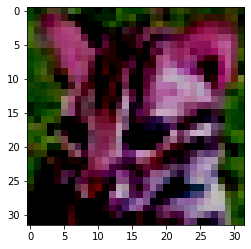

In [76]:
images = images.cpu()
plt.imshow(images[0].permute(1,2,0).numpy())
print(classes[labels[0].numpy()])

In [77]:
model.eval()
with torch.no_grad():
  images = images.cuda()
  out = model(images[0].reshape(1,3,32,32))
  _ , h = out.max(1)
classes[h]

'cat'